# Convolutional Neural Network and Model Interpretation

- Train a convolutional neural network
- Visualize the last "feature" layer
- Visualize filters in the first convolution layer
- Visualize activation regions of the input image

### Setup drive

Run the following cell to mount your Drive onto Colab. Go to the given URL and once you login and copy and paste the authorization code, you should see "drive" pop up in the files tab on the left.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
drive.flush_and_unmount()

Click the little triangle next to "drive" and navigate to the "AI4All Chest X-Ray Project" folder. Hover over the folder and click the 3 dots that appear on the right. Select "copy path" and replace `PASTE PATH HERE` with the path to your folder.

In [ ]:
# cd "PASTE PATH HERE"

In [ ]:
c

In [ ]:
cd "/content/drive/My Drive/AI4All Project/AI4All Chest X-Ray Project"

/content/drive/My Drive/AI4All Project/AI4All Chest X-Ray Project


### Import necessary libraries

In [ ]:
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split

import torchvision
from torchvision import datasets, models, transforms

from utils.datahelper import get_random_image
from utils.plotting import imshow_dataset, imshow_filters, plot_accuracy_curves, plot_loss_curve
from utils.modelhelper import calc_accuracy, get_train_validate_sizes, predict, train, visualize_cam, GradCAM

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Setup paths

In [ ]:
path_to_dataset = os.path.join('data')

path_to_images = os.path.join(path_to_dataset, 'images')
path_to_multiclass = os.path.join(path_to_dataset, 'multiclass')
path_to_test_images = os.path.join(path_to_dataset, 'test')

metadata = pd.read_csv(os.path.join(path_to_dataset, 'metadata_train.csv'))

## Convolutional Neural Network (CNN)

### Preprocess and split data 

The preprocessing and data splitting steps are the same as for the fully connected network

**Preprocess data**

Define preprocessing transforms


In [31]:
DATA_MEAN = 0.544
DATA_STD = 0.237

RESIZE_SIZE = 235
CROP_SIZE = 200
IM_SIZE = CROP_SIZE

# preprocess transforms
data_transforms = transforms.Compose([
            transforms.Grayscale(),
            transforms.Resize(RESIZE_SIZE),
            transforms.CenterCrop(CROP_SIZE),
            transforms.ToTensor(),
            transforms.Normalize(mean=DATA_MEAN, std=DATA_STD)])

Sample data augmentation transforms (not used). Modify this code if you want to use augmentation!

In [32]:
# Framework for using data augmentation (not optimized)

RESIZE_SIZE = 235
CROP_SIZE = 200
IM_SIZE = CROP_SIZE

DEGREE = 10
augmentation_transforms = [transforms.RandomAffine(degrees=DEGREE,
                                                   translate=((DEGREE / 100), (DEGREE/ 100)),
                                                   scale=(1 - (DEGREE / 100), 1 + (DEGREE / 100)),
                                                   shear=0),
                            transforms.RandomHorizontalFlip()]

data_transforms_augmented = transforms.Compose([
            transforms.Grayscale(),
            transforms.Resize(RESIZE_SIZE),
            *augmentation_transforms,
            transforms.CenterCrop(CROP_SIZE),
            transforms.ToTensor(),
            transforms.Normalize(mean=DATA_MEAN, std=DATA_STD)])

In [33]:
dataset_aug = datasets.ImageFolder(path_to_images, transform=data_transforms_augmented)

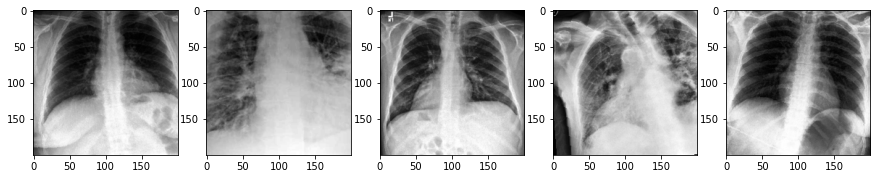

In [ ]:
imshow_dataset(dataset_aug, rand=True)

Create image dataset using defined transforms

In [ ]:
dataset = datasets.ImageFolder(path_to_images, transform=data_transforms)

**Split the data into training and validation set**

Randomly split dataset into training and validation set. Use DataLoaders define how to load data from training and validation datasets.



In [ ]:
TRAIN_RATIO = 0.75
BATCH_SIZE = 64

# calculate training and validation set sizes
train_size, validate_size = get_train_validate_sizes(dataset, TRAIN_RATIO)

# split dataset into two training set and validation set
train_dataset, validate_dataset = random_split(dataset, [train_size, validate_size])

# create dataloaders
train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=BATCH_SIZE)
validate_loader = DataLoader(dataset=validate_dataset, shuffle=False, batch_size=len(validate_dataset))


**Using test set as validation set**

No patient overlap

In [34]:
train_dataset = datasets.ImageFolder(path_to_images, transform=data_transforms_augmented)
validate_dataset = datasets.ImageFolder(path_to_test_images, transform=data_transforms)

# create dataloaders
train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=BATCH_SIZE)
validate_loader = DataLoader(dataset=validate_dataset, shuffle=False, batch_size=len(validate_dataset))

### Ignore this

Calculate convolution output / linear input size for the `nn.Sequential` container. There may be a better way to do this (without using `nn.Module`).


In [35]:
def calc_conv2d_dim(w, p=0, d=1, k=3, s=1):
    '''Calculate output dimension of a conv2d layer. Assumes input width=height 
    and kernels are square

    Args:
      w: input width/height (assumed equal)
      p: padding
      d: dilation
      k: kernel size (assumed equal)
      s: stride

    Returns: output dimension (width = height) 
    '''

    return math.floor((w + 2*p - d*(k-1) - 1) / s + 1)

In [36]:
def calc_maxpool2d_dim(w, p=0, d=1, k=2, s=2):
    '''Calculate output dimension of a maxpool2d layer. Assumes input width=height 
    and kernels are square

    Args:
      w: input width/height (assumed equal)
      p: padding
      d: dilation
      k: kernel size (assumed equal)
      s: stride

    Returns: output dimension (width = height) 
    '''
    return math.floor((w + 2*p - d*(k-1) - 1) / s + 1)

Calculate the convolution block output size. 

To calculate the input size for the first linear layer in the fully connected block: k x w x h

k: number of kernels in the last conv layer

w = h: convolution block output size

In [37]:
# order of conv2d and maxpool2d layers as a string
layers = 'cmcm'

current_size = IM_SIZE

# calculate convolution block output size
# modify if you need to parameterize layers individually
for l in layers:
    if l == 'c':
        current_size = calc_conv2d_dim(current_size, k=3)
    elif l == 'm':
        current_size = calc_maxpool2d_dim(current_size)

cnn_out_size = current_size
print(f'Convolution block output size: {cnn_out_size}')


Convolution block output size: 48


### Setup and train CNN

**Define CNN**

The CNN network consists of a convolution section followed by a fully connected section. The convolutin section is a sequence of convolution (`nn.Conv2d`) layers followed up by activation (`nn.ReLu`) and max pooling (`nn.MaxPool2d`). 

The output from the convolution section is then flattened (`nn.Flatten`) for the fully connected section.

As before, the fully connected layer is a sequence of linear (`nn.Linear`) layers followed by activation (`nn.ReLu`). 

We end the network with an output linear layer followed by log softmax (`nn.LogSoftmax`). This outputs the log probability (likelihood) for each class label.

Read about convolution layers in PyTorch [here](https://pytorch.org/docs/master/nn.html#convolution-layers)

In [42]:
model = nn.Sequential(nn.Conv2d(1, 16, 3),
                      nn.ReLU(),
                      nn.MaxPool2d(2, 2),
                      nn.Conv2d(16, 16, 3),
                      nn.ReLU(),
                      nn.MaxPool2d(2, 2),
                      nn.Flatten(),
                      nn.Linear(16 * cnn_out_size * cnn_out_size, 32),
                      nn.ReLU(),
                      nn.Linear(32,  8),
                      nn.ReLU(),
                      nn.Linear(8, 2),
                      nn.LogSoftmax(dim=1))

print(model)

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten()
  (7): Linear(in_features=36864, out_features=32, bias=True)
  (8): ReLU()
  (9): Linear(in_features=32, out_features=8, bias=True)
  (10): ReLU()
  (11): Linear(in_features=8, out_features=2, bias=True)
  (12): LogSoftmax()
)


**Train CNN**

Same function as for fully connected NN

In [39]:
train_accuracy_log, validate_accuracy_log, loss_log = train(model, train_loader, validate_loader, epoch_num=1)

[epoch 0 batch 0] Loss: 0.697 Train accuracy: 0.531 Val accuracy: 0.500
[epoch 0 batch 1] Loss: 0.721 Train accuracy: 0.453 Val accuracy: 0.535
[epoch 0 batch 2] Loss: 0.683 Train accuracy: 0.484 Val accuracy: 0.512
[epoch 0 batch 3] Loss: 0.653 Train accuracy: 0.547 Val accuracy: 0.581
[epoch 0 batch 4] Loss: 0.614 Train accuracy: 0.656 Val accuracy: 0.698
[epoch 0 batch 5] Loss: 0.558 Train accuracy: 0.750 Val accuracy: 0.849
[epoch 0 batch 6] Loss: 0.524 Train accuracy: 0.812 Val accuracy: 0.779
[epoch 0 batch 7] Loss: 0.547 Train accuracy: 0.703 Val accuracy: 0.779
[epoch 0 batch 8] Loss: 0.510 Train accuracy: 0.719 Val accuracy: 0.942
[epoch 0 batch 9] Loss: 0.470 Train accuracy: 0.891 Val accuracy: 0.779
[epoch 0 batch 10] Loss: 0.545 Train accuracy: 0.688 Val accuracy: 0.872
[epoch 0 batch 11] Loss: 0.446 Train accuracy: 0.781 Val accuracy: 0.814
[epoch 0 batch 12] Loss: 0.594 Train accuracy: 0.727 Val accuracy: 0.919
Finished Training


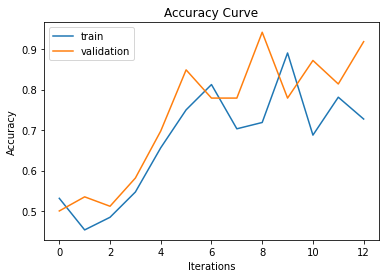

In [41]:
plot_accuracy_curves(train_accuracy_log, validate_accuracy_log)

**Multiclass**

In [ ]:
# load multiclass training set
train_dataset = datasets.ImageFolder(path_to_multiclass, transform=data_transforms)

In [ ]:
# modify model
model = nn.Sequential(nn.Conv2d(1, 8, 3),
                      nn.ReLU(),
                      nn.MaxPool2d(2, 2),
                      nn.Conv2d(8, 8, 3),
                      nn.ReLU(),
                      nn.MaxPool2d(2, 2),
                      nn.Flatten(),
                      nn.Linear(8 * cnn_out_size * cnn_out_size, 8),
                      nn.ReLU(),
                      nn.Linear(8,  8),
                      nn.ReLU(),
                      nn.Linear(8, 23),
                      nn.LogSoftmax(dim=1))

print(model)

Sequential(
  (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten()
  (7): Linear(in_features=23328, out_features=8, bias=True)
  (8): ReLU()
  (9): Linear(in_features=8, out_features=8, bias=True)
  (10): ReLU()
  (11): Linear(in_features=8, out_features=23, bias=True)
  (12): LogSoftmax()
)


In [ ]:
train_accuracy_log, validate_accuracy_log, loss_log = train(model, train_loader, train_loader, epoch_num=1)

[epoch 0 batch 0] Loss: 2.972 Train accuracy: 0.000 Val accuracy: 0.000
[epoch 0 batch 1] Loss: 2.736 Train accuracy: 0.000 Val accuracy: 0.000
[epoch 0 batch 2] Loss: 2.630 Train accuracy: 0.000 Val accuracy: 0.484
[epoch 0 batch 3] Loss: 2.565 Train accuracy: 0.484 Val accuracy: 0.500
[epoch 0 batch 4] Loss: 2.581 Train accuracy: 0.500 Val accuracy: 0.500
[epoch 0 batch 5] Loss: 2.233 Train accuracy: 0.625 Val accuracy: 0.453
[epoch 0 batch 6] Loss: 2.543 Train accuracy: 0.438 Val accuracy: 0.500
[epoch 0 batch 7] Loss: 2.642 Train accuracy: 0.375 Val accuracy: 0.500
[epoch 0 batch 8] Loss: 2.375 Train accuracy: 0.500 Val accuracy: 0.500
[epoch 0 batch 9] Loss: 2.164 Train accuracy: 0.594 Val accuracy: 0.500
[epoch 0 batch 10] Loss: 2.301 Train accuracy: 0.500 Val accuracy: 0.500
[epoch 0 batch 11] Loss: 2.333 Train accuracy: 0.453 Val accuracy: 0.500
[epoch 0 batch 12] Loss: 2.463 Train accuracy: 0.409 Val accuracy: 0.500
Finished Training


## Model Interpretation

This section walks through three approaches for model interpretation, or understanding how a neural network makes its decisions. 

Don't worry about the code in this section as it's a bit more complicated. We will focus on the visualizations and interpretations as we go through the section together.



### Visualize features in fully connected layer


We can visualize the feautures being learned in a fully connected layer by recording and plotting the layer activations for a given set of input images. The space of the features is also called the latent space. Here, we take a look at the last layer before the output layer.


In [43]:
def save_output_hook(module, input, output):
    '''Hook for saving module output to module'''
    setattr(module, '_output_hook', output)

In [44]:
def get_feature_outputs(model, test_loader, layer_num=-3, inputs_num=300):
  '''Get outputs for the feauture layer. Default feature layer is the fully 
  connected layer right before the output layer

  Args:
    model: neural network
    test_loader: DataLoader for test images
    layer_num: layer number for activation (e.g. relu) layer of the feature layer
    inputs_num: number of test inputs to run

  Returns: layer_outputs, actual_labels
  '''

  # register a hook to save the output
  output_handle = model[layer_num].register_forward_hook(save_output_hook)

  layer_outputs = []
  labels = []

  for i in range(inputs_num):

    # get the next image
    input, label = next(iter(test_loader))

    # forward pass with an input image
    output = model(input)

    # get the activation value
    layer_output = model[layer_num]._output_hook.data
    layer_output = layer_output[0].numpy()

    layer_outputs.append(layer_output)
    labels.append(label.item())

  # remove hook
  output_handle.remove()

  layer_outputs = np.array(layer_outputs)

  return layer_outputs, labels


In [45]:
# define test data loader
dataset_test = datasets.ImageFolder(path_to_images, transform=data_transforms)
test_loader = DataLoader(dataset=dataset_test, shuffle=True, batch_size=1)

In [46]:
# get feature activations before training
activation_pretrain, labels_pretrain = get_feature_outputs(model, test_loader)

train_accuracy_log = []
validate_accuracy_log = []
loss_log = []

# get feature activations after training for one epoch
training_output = train(model, train_loader, validate_loader, epoch_num=1)

train_accuracy_log += training_output[0]
validate_accuracy_log += training_output[1]
loss_log += training_output[2]

activation_train1, labels_train1 = get_feature_outputs(model, test_loader)

# get feature activations after training for another 4 epochs
training_output = train(model, train_loader, validate_loader, epoch_num=4)

train_accuracy_log += training_output[0]
validate_accuracy_log += training_output[1]
loss_log += training_output[2]

activation_train2, labels_train2 = get_feature_outputs(model, test_loader)

[epoch 0 batch 0] Loss: 0.704 Train accuracy: 0.484 Val accuracy: 0.430
[epoch 0 batch 1] Loss: 0.718 Train accuracy: 0.391 Val accuracy: 0.500
[epoch 0 batch 2] Loss: 0.971 Train accuracy: 0.469 Val accuracy: 0.640
[epoch 0 batch 3] Loss: 0.675 Train accuracy: 0.594 Val accuracy: 0.500
[epoch 0 batch 4] Loss: 0.758 Train accuracy: 0.531 Val accuracy: 0.570
[epoch 0 batch 5] Loss: 0.779 Train accuracy: 0.516 Val accuracy: 0.686
[epoch 0 batch 6] Loss: 0.663 Train accuracy: 0.688 Val accuracy: 0.500
[epoch 0 batch 7] Loss: 0.707 Train accuracy: 0.422 Val accuracy: 0.500
[epoch 0 batch 8] Loss: 0.678 Train accuracy: 0.594 Val accuracy: 0.500
[epoch 0 batch 9] Loss: 0.709 Train accuracy: 0.453 Val accuracy: 0.500
[epoch 0 batch 10] Loss: 0.682 Train accuracy: 0.562 Val accuracy: 0.500
[epoch 0 batch 11] Loss: 0.697 Train accuracy: 0.500 Val accuracy: 0.500
[epoch 0 batch 12] Loss: 0.697 Train accuracy: 0.500 Val accuracy: 0.500
Finished Training
[epoch 0 batch 0] Loss: 0.690 Train accurac

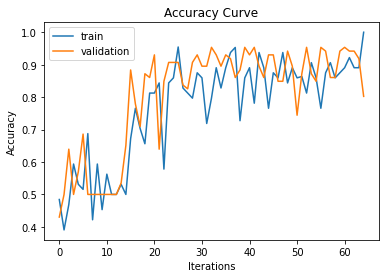

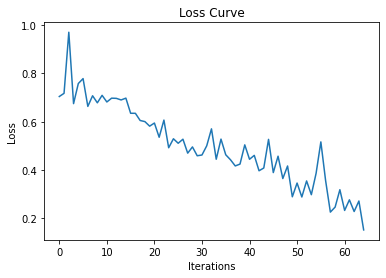

In [47]:
# plot training curves
plot_accuracy_curves(train_accuracy_log, validate_accuracy_log)
plot_loss_curve(loss_log)d

In [53]:
# get feature activations after training for another 5 epochs
training_output = train(model, train_loader, validate_loader, epoch_num=5)

train_accuracy_log += training_output[0]
validate_accuracy_log += training_output[1]
loss_log += training_output[2]

activation_train3, labels_train3 = get_feature_outputs(model, test_loader)

[epoch 0 batch 0] Loss: 0.354 Train accuracy: 0.828 Val accuracy: 0.767
[epoch 0 batch 1] Loss: 0.800 Train accuracy: 0.672 Val accuracy: 0.767
[epoch 0 batch 2] Loss: 0.724 Train accuracy: 0.672 Val accuracy: 0.860
[epoch 0 batch 3] Loss: 0.559 Train accuracy: 0.750 Val accuracy: 0.930
[epoch 0 batch 4] Loss: 0.270 Train accuracy: 0.922 Val accuracy: 0.860
[epoch 0 batch 5] Loss: 0.392 Train accuracy: 0.828 Val accuracy: 0.767
[epoch 0 batch 6] Loss: 0.433 Train accuracy: 0.781 Val accuracy: 0.930
[epoch 0 batch 7] Loss: 0.509 Train accuracy: 0.812 Val accuracy: 0.919
[epoch 0 batch 8] Loss: 0.286 Train accuracy: 0.906 Val accuracy: 0.907
[epoch 0 batch 9] Loss: 0.327 Train accuracy: 0.891 Val accuracy: 0.884
[epoch 0 batch 10] Loss: 0.351 Train accuracy: 0.875 Val accuracy: 0.884
[epoch 0 batch 11] Loss: 0.444 Train accuracy: 0.844 Val accuracy: 0.895
[epoch 0 batch 12] Loss: 0.344 Train accuracy: 0.909 Val accuracy: 0.907
[epoch 1 batch 0] Loss: 0.261 Train accuracy: 0.953 Val accur

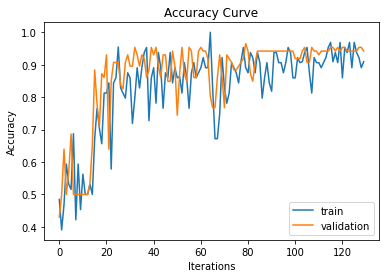

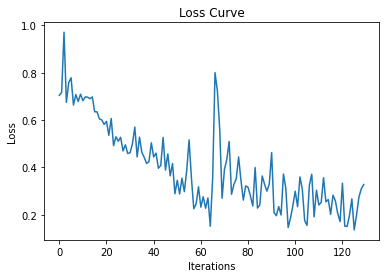

In [55]:
# plot training curves
plot_accuracy_curves(train_accuracy_log, validate_accuracy_log)
plot_loss_curve(loss_log)

In [48]:
from sklearn.manifold import TSNE

def plot_tsne(activations, labels, ax):
  '''Compute and plot tsne plot'''

  tsne = TSNE(n_components=2, perplexity=40, n_iter=5000)
  feature_tsne = tsne.fit_transform(activations)

  df_tsne = pd.DataFrame({
      'tsne_x': feature_tsne[:,0],
      'tsne_y': feature_tsne[:,1],
      'target_labels': labels})

  sns.scatterplot(x='tsne_x', y='tsne_y', hue='target_labels', data=df_tsne, legend='full', ax=ax)

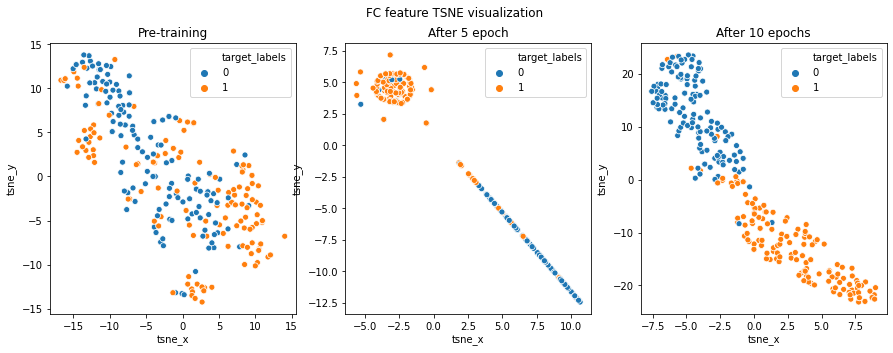

In [90]:
# plot tsne plots
fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax = ax.ravel()

plot_tsne(activation_pretrain, labels_pretrain, ax=ax[0])
ax[0].set_title('Pre-training')
plot_tsne(activation_train1, labels_train1, ax=ax[1])
ax[1].set_title('After 5 epoch')
plot_tsne(activation_train3, labels_train3, ax=ax[2])
ax[2].set_title('After 10 epochs')

plt.suptitle('FC feature TSNE visualization')
plt.show()


In [58]:
from sklearn.decomposition import PCA

def plot_pca(activations, labels, ax):
  '''Compute and plot PCA plot'''

  pca = PCA(n_components=2)
  feature_pca = pca.fit_transform(activations)

  df_pca = pd.DataFrame({
      'pca1': feature_pca[:,0],
      'pca2': feature_pca[:,1],
      'target_labels': labels})

  sns.scatterplot(x='pca1', y='pca2', hue='target_labels', data=df_pca, legend='full', ax=ax)


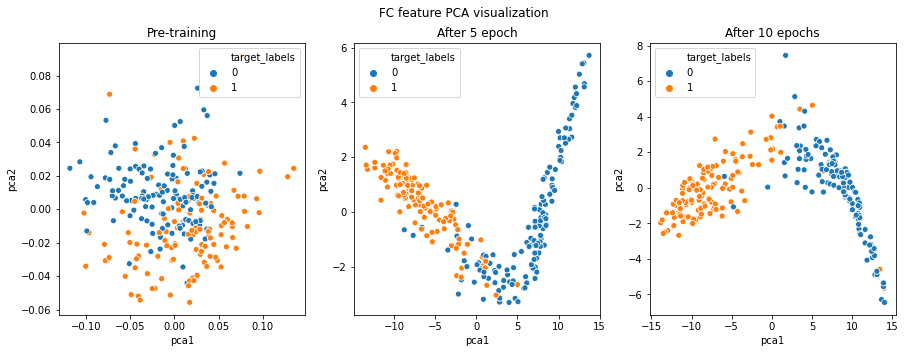

In [60]:
# plot pca plots
fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax = ax.ravel()

plot_pca(activation_pretrain, labels_pretrain, ax=ax[0])
ax[0].set_title('Pre-training')
plot_pca(activation_train2, labels_train2, ax=ax[1])
ax[1].set_title('After 5 epoch')
plot_pca(activation_train3, labels_train3, ax=ax[2])
ax[2].set_title('After 10 epochs')

plt.suptitle('FC feature PCA visualization')
plt.show()

### Visualize CNN filters

We can also visualize the filters being learned in the first convolution layer of a CNN

**Show filters for the CNN we just trained**

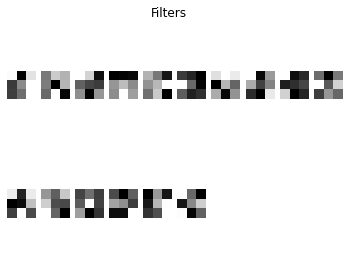

In [61]:
# get filters from the first convolution layer
filters = model[0].weight.data
imshow_filters(filters, single_channel=True)

**Show filters for a pre-trained model (AlexNet)**

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth


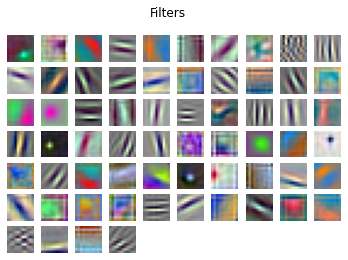

In [ ]:
# load pre-trained alexnet
alexnet = models.alexnet(pretrained=True)

# get first layer weights
filters = alexnet.features[0].weight.data
imshow_filters(filters)

**Show filters for a pre-trained model (VGG16)**

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


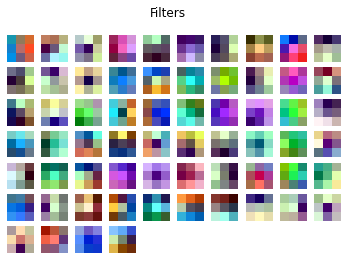

In [ ]:
# load vgg
vgg16 = models.vgg16(pretrained=True)

# get first layer weights
filters = vgg16.features[0].weight.data
imshow_filters(filters)

### Class activation maps

Class activation maps (CAMs) show which region of the image is being used (activated) to make the prediction.

In [64]:
def show_random_gradcam(model, target_layer, dataset):
  # get a random image
  im = get_random_image(dataset)
  im_batch = torch.stack([im])

  # run gradient class activation mapping
  gradcam = GradCAM(model, target_layer)
  mask, logit = gradcam(im_batch)
  heatmap, cam_result = visualize_cam(mask, im_batch)

  # show results
  fig, ax = plt.subplots(1,3)
  plt.gray()
  ax[0].imshow(np.squeeze(im))
  ax[1].imshow(transforms.ToPILImage()(heatmap))
  ax[2].imshow(transforms.ToPILImage()(cam_result))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2796: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


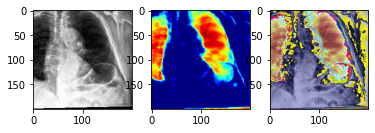

In [72]:
# find the last convolution layer and set as target layer
target_layer = model._modules['3']

show_random_gradcam(model, target_layer, train_dataset)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2796: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


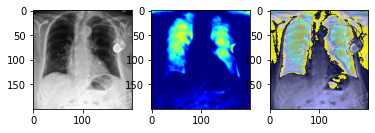

In [87]:
show_random_gradcam(model, target_layer, validate_dataset)

**Pre-trained dataset and model**

https://pytorch.org/docs/stable/torchvision/datasets.html

In [ ]:
from torchvision import datasets

rootpath = os.path.join(path_to_dataset, 'loaded_dataset')
print(rootpath)
mnist_dataset = datasets.MNIST(rootpath, train=False, transform=None, target_transform=None, download=True)

data/loaded_dataset


Extracting data/loaded_dataset/MNIST/raw/train-images-idx3-ubyte.gz to data/loaded_dataset/MNIST/raw



Extracting data/loaded_dataset/MNIST/raw/train-labels-idx1-ubyte.gz to data/loaded_dataset/MNIST/raw


Extracting data/loaded_dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to data/loaded_dataset/MNIST/raw


Extracting data/loaded_dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/loaded_dataset/MNIST/raw
Processing...


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Done!


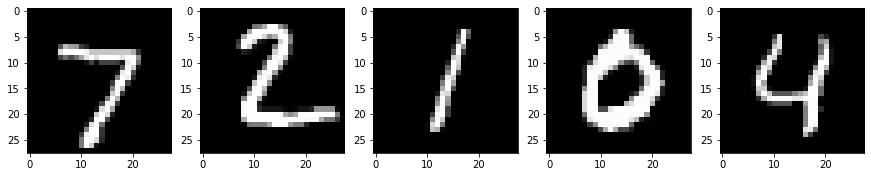

In [ ]:
imshow_dataset(mnist_dataset)

In [ ]:
fmnist_dataset = datasets.FashionMNIST(rootpath, train=False, transform=None, target_transform=None, download=True)

Extracting data/loaded_dataset/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/loaded_dataset/FashionMNIST/raw


Extracting data/loaded_dataset/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/loaded_dataset/FashionMNIST/raw


Extracting data/loaded_dataset/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/loaded_dataset/FashionMNIST/raw





Extracting data/loaded_dataset/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/loaded_dataset/FashionMNIST/raw
Processing...
Done!


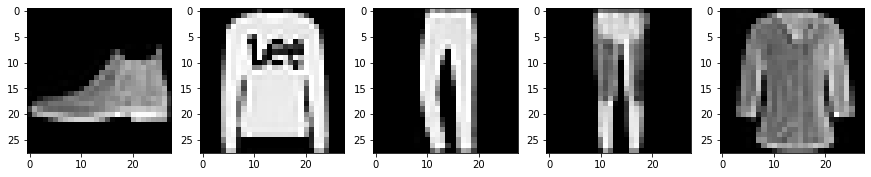

In [ ]:
imshow_dataset(fmnist_dataset)

**Pre-trained models**


In [ ]:
# load vgg
vgg16 = models.vgg16(pretrained=True)

# get first layer weights
predict(vgg16, image_dataset)